  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



Ep 1/500  train_loss=nan  val_loss=1.5321  lam=0.500  eps=0.995
Ep 2/500  train_loss=0.9515  val_loss=0.7778  lam=0.525  eps=0.990
Ep 3/500  train_loss=0.2612  val_loss=0.1164  lam=0.549  eps=0.985
Ep 4/500  train_loss=0.0352  val_loss=0.0494  lam=0.551  eps=0.980
Ep 5/500  train_loss=0.0130  val_loss=0.0356  lam=0.552  eps=0.975
Ep 6/500  train_loss=0.0045  val_loss=0.0122  lam=0.552  eps=0.970
Ep 7/500  train_loss=0.0029  val_loss=0.0095  lam=0.552  eps=0.966
Ep 8/500  train_loss=0.0022  val_loss=0.0030  lam=0.552  eps=0.961
Ep 9/500  train_loss=0.0019  val_loss=0.0095  lam=0.552  eps=0.956
Ep 10/500  train_loss=0.0020  val_loss=0.0023  lam=0.552  eps=0.951
Ep 11/500  train_loss=0.2084  val_loss=0.1056  lam=0.646  eps=0.946
Ep 12/500  train_loss=0.0406  val_loss=0.1485  lam=0.658  eps=0.942
Ep 13/500  train_loss=0.0466  val_loss=0.0341  lam=0.678  eps=0.937
Ep 14/500  train_loss=0.0389  val_loss=0.0559  lam=0.684  eps=0.932
Ep 15/500  train_loss=0.0481  val_loss=0.0217  lam=0.713  ep

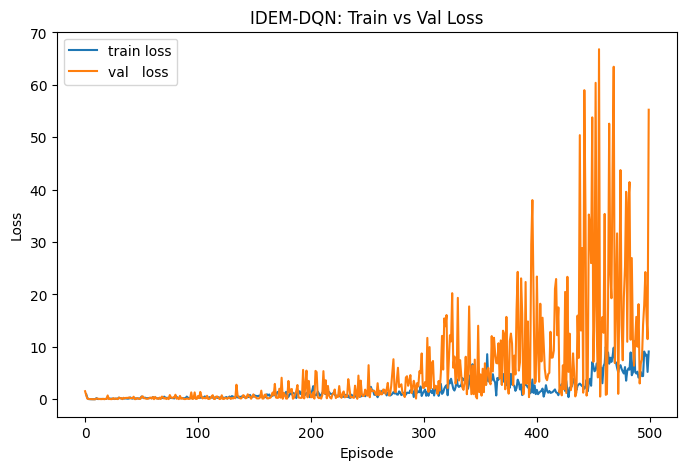

In [3]:
# ────────────────────────────────────────────────────────────────────────────────
# Full IDEM-DQN + Loss Tracking + Inline Video Display (Colab-style)
# ────────────────────────────────────────────────────────────────────────────────

# 1) Setup & compatibility hacks
import numpy as np
if not hasattr(np, 'bool8'):  # satisfy Gym’s passive_env_checker
    np.bool8 = np.bool_

import random, gym, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras import layers, models
from collections import deque
from IPython.display import Video  # for inline playback

# 2) Gym API wrappers (works with both old and new Gym)
def reset_env(env):
    out = env.reset()
    return out[0] if isinstance(out, tuple) else out

def step_env(env, action):
    out = env.step(action)
    if len(out) == 5:  # new Gym: (obs, reward, terminated, truncated, info)
        obs, reward, term, trunc, info = out
        done = term or trunc
    else:             # old Gym: (obs, reward, done, info)
        obs, reward, done, info = out
    return obs, reward, done, info

# 3) Hyperparameters
gamma               = 0.99
epsilon             = 1.0
epsilon_min         = 0.01
epsilon_decay       = 0.995
lr                  = 0.001
batch_size          = 32
n_episodes          = 500
buffer_max_size     = 5000
update_target_every = 10
ema_beta            = 0.99
val_buffer_size     = 1000

# 4) Model builders
def build_q_model(s_dim, a_dim):
    inp = layers.Input(shape=(s_dim,))
    x = layers.Dense(64, activation='relu')(inp)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(a_dim, activation='linear')(x)
    m = models.Model(inp, out)
    m.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse')
    return m

def build_dyn_model(s_dim, a_dim):
    inp = layers.Input(shape=(s_dim + a_dim,))
    x = layers.Dense(64, activation='relu')(inp)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(s_dim, activation='linear')(x)
    m = models.Model(inp, out)
    m.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse')
    return m

# 5) Replay Buffer
class ReplayBuffer:
    def __init__(self, maxlen):
        self.buf = deque(maxlen=maxlen)
    def add(self, e):
        self.buf.append(e)
    def sample(self, n):
        return random.sample(self.buf, n)
    def size(self):
        return len(self.buf)

# 6) Epsilon-greedy action selection
def select_action(state, model, eps, a_dim):
    if np.random.rand() < eps:
        return random.randrange(a_dim)
    return np.argmax(model.predict(state[None], verbose=0)[0])

# 7) Train, record, and display inline
def train_and_show():
    global epsilon

    # — Create env & fill validation buffer
    env = gym.make('CartPole-v1')
    s_dim, a_dim = env.observation_space.shape[0], env.action_space.n

    val_buf = ReplayBuffer(val_buffer_size)
    s = reset_env(env)
    while val_buf.size() < val_buffer_size:
        a = env.action_space.sample()
        ns, r, done, _ = step_env(env, a)
        val_buf.add((s, a, r, ns, done))
        s = ns if not done else reset_env(env)

    # — Build Q-networks and dynamics model
    q_model   = build_q_model(s_dim, a_dim)
    target_q  = build_q_model(s_dim, a_dim)
    target_q.set_weights(q_model.get_weights())
    dyn_model = build_dyn_model(s_dim, a_dim)

    opt_q   = tf.keras.optimizers.Adam(lr)
    opt_dyn = tf.keras.optimizers.Adam(lr)

    # — Track losses
    train_losses, val_losses = [], []
    td_ema, mod_ema = 1.0, 1.0

    # — Persistent training buffer
    buffer = ReplayBuffer(buffer_max_size)

    for ep in range(1, n_episodes+1):
        lam = td_ema / (td_ema + mod_ema + 1e-8)
        s, done = reset_env(env), False
        ep_losses = []

        # — One episode of data collection + updates
        while not done:
            a = select_action(s, q_model, epsilon, a_dim)
            ns, r, done, _ = step_env(env, a)
            buffer.add((s, a, r, ns, done))
            s = ns

            if buffer.size() >= batch_size:
                batch = buffer.sample(batch_size)
                S  = np.vstack([b[0] for b in batch])
                A  = np.array([b[1] for b in batch])
                R  = np.array([b[2] for b in batch], dtype=np.float32)
                NS = np.vstack([b[3] for b in batch])
                D  = np.array([b[4] for b in batch], dtype=np.float32)
                A_oh = tf.one_hot(A, a_dim)

                with tf.GradientTape(persistent=True) as tape:
                    # TD loss
                    Q      = q_model(S, training=True)
                    Qsel   = tf.reduce_sum(Q * A_oh, axis=1)
                    Qnext  = target_q(NS, training=False)
                    targ   = R + (1 - D) * gamma * tf.reduce_max(Qnext, axis=1)
                    l_td   = tf.reduce_mean((targ - Qsel)**2)
                    # Dynamics loss
                    inp    = tf.concat([S, A_oh], axis=1)
                    pred   = dyn_model(inp, training=True)
                    l_mod  = tf.reduce_mean((NS - pred)**2)
                    # Combined
                    lam    = td_ema / (td_ema + mod_ema + 1e-8)
                    loss   = l_td + lam * l_mod

                grads_q   = tape.gradient(loss, q_model.trainable_variables)
                grads_mod = tape.gradient(l_mod,  dyn_model.trainable_variables)
                opt_q.apply_gradients(zip(grads_q,   q_model.trainable_variables))
                opt_dyn.apply_gradients(zip(grads_mod, dyn_model.trainable_variables))
                del tape

                # EMA updates
                td_ema   = ema_beta * td_ema   + (1 - ema_beta) * l_td.numpy()
                mod_ema  = ema_beta * mod_ema  + (1 - ema_beta) * l_mod.numpy()
                ep_losses.append(loss.numpy())

        # — Episode end bookkeeping
        train_losses.append(np.mean(ep_losses))
        # Validation loss
        vb = val_buf.sample(batch_size)
        VS  = np.vstack([b[0] for b in vb])
        VA  = np.array([b[1] for b in vb])
        VNS = np.vstack([b[3] for b in vb])
        VD  = np.array([b[4] for b in vb], dtype=np.float32)
        VA_oh = tf.one_hot(VA, a_dim)

        Qv     = q_model(VS, training=False)
        Qvsel  = tf.reduce_sum(Qv * VA_oh, axis=1).numpy()
        Qvnext = target_q(VNS, training=False)
        vtarg  = np.array([b[2] for b in vb], dtype=np.float32) + \
                 (1 - VD)*gamma*np.max(Qvnext, axis=1)
        l_td_v = np.mean((vtarg - Qvsel)**2)
        inp_v   = tf.concat([VS, VA_oh], axis=1)
        pred_v  = dyn_model(inp_v, training=False).numpy()
        l_mod_v = np.mean((VNS - pred_v)**2)
        val_losses.append(l_td_v + l_mod_v)

        # Decay & target‐net update
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        if ep % update_target_every == 0:
            target_q.set_weights(q_model.get_weights())

        print(f"Ep {ep}/{n_episodes}  train_loss={train_losses[-1]:.4f}  "
              f"val_loss={val_losses[-1]:.4f}  lam={lam:.3f}  eps={epsilon:.3f}")

    # — Plot losses
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses,   label='val   loss')
    plt.xlabel('Episode'); plt.ylabel('Loss')
    plt.legend(); plt.title('IDEM-DQN: Train vs Val Loss')
    plt.show()


# 8) Run training and show the video inline
train_and_show()


In [4]:
from moviepy.editor import ImageSequenceClip
from IPython.display       import Video

# (Re-run your rollout code to get `frames`, but without pip installs)
demo_env = gym.make('CartPole-v1', render_mode='rgb_array')
frames, s, done = [], reset_env(demo_env), False
while len(frames) < 150 and not done:
    frames.append(demo_env.render())
    a = select_action(s, q_model, 0.0, a_dim)
    s, _, done, _ = step_env(demo_env, a)
demo_env.close()

# Convert and write MP4
import numpy as np
frames = [np.asarray(f) for f in frames]
clip   = ImageSequenceClip(frames, fps=30)
clip.write_videofile('/content/demo.mp4', codec='libx264', verbose=False)

# Show inline
Video('/content/demo.mp4', embed=True, width=480)



NameError: name 'q_model' is not defined